In [9]:
import pandas as pd
import numpy as np
from neo4j import GraphDatabase
import igraph as ig
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from chart_studio import plotly as py
from plotly.graph_objs import *
from plotly.offline import iplot
from py2neo import Graph

# graph = Graph("bolt://localhost:7687", auth=("neo4j", "neo4jneo4j"))

In [3]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "neo4jneo4j"))
session = driver.session()

In [4]:
edges = list()
edge_w = list()
vertices = dict()

# results = session.run("MATCH (n:Person)-[r:INTERACTS_1|INTERACTS_2|INTERACTS_3|INTERACTS_4]-(m:Person) "
#                       "WHERE(n.community_S1234) IS NOT NULL AND (m.community_S1234) IS NOT NULL "
#                       "RETURN n, m, r")

# results = session.run("MATCH (n:Person)-[r:INTERACTS_5|INTERACTS_6]-(m:Person) "
#                       "WHERE(n.community_S56) IS NOT NULL AND (m.community_S56) IS NOT NULL "
#                       "RETURN n, m, r")

results = session.run("MATCH (n:Person)-[r:INTERACTS_7|INTERACTS_8]-(m:Person) "\
                      "WHERE(n.community_S78) IS NOT NULL AND (m.community_S78) IS NOT NULL "\
                      "RETURN n, m, r")


g = ig.Graph()

for result in results:
  vertices[str(result["n"]["label"])] = str(result["n"]["community_S78"])
  vertices[str(result["m"]["label"])] = str(result["m"]["community_S78"])
  edges.append([str(result["n"]["label"]), str(result["m"]["label"])])
  edge_w.append(1/result["r"]["weight"])

g.add_vertices(list(vertices.keys()))
g.add_edges(edges)
g.es["weight"]=edge_w
g.vs["community"] = list(vertices.values())
N = len(g.vs)
E=[e.tuple for e in g.es]

In [5]:
community_list = list(set(list(vertices.values())))
k = len(community_list)

colors = px.colors.qualitative.Plotly[:k]

g.vs['color'] = [None]

color_list= list()

In [6]:
for i in list(vertices.values()):
    color_id = community_list.index(i)
    color_list.append(colors[color_id])

In [7]:
g.vs['color'] = color_list

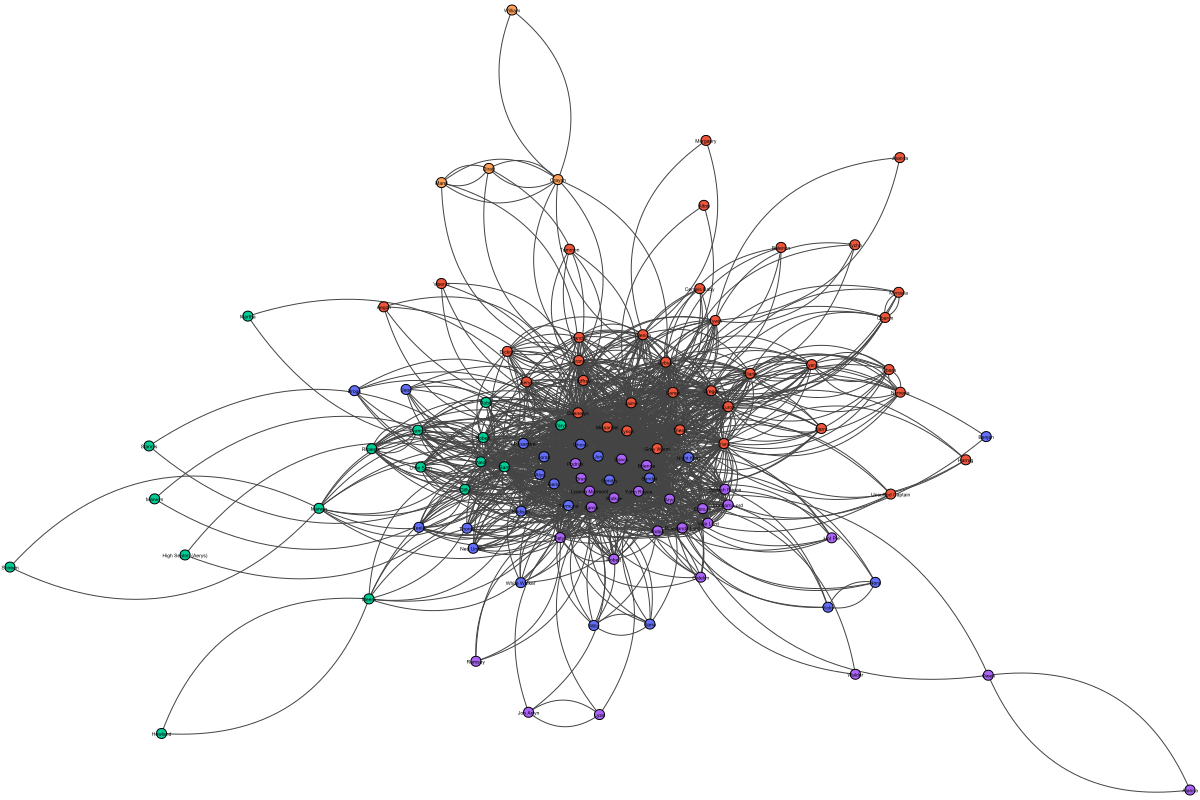

In [8]:

# Calculate layout
layt = g.layout("fr")

# Define style from network plotting
visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_label_size"] = 5
visual_style["vertex_color"] = g.vs["color"]
visual_style["vertex_label"] = g.vs["name"]
visual_style["layout"] = layt
visual_style["bbox"] = (1200, 800)
visual_style["margin"] = 10

ig.plot(g, **visual_style)


In [11]:
Xn = [layt[k][0] for k in range(N)]
Yn = [layt[k][1] for k in range(N)]
Xe = []
Ye = []
for e in E:
    Xe += [layt[e[0]][0], layt[e[1]][0], None]
    Ye += [layt[e[0]][1], layt[e[1]][1], None]

fig = go.Figure()

trace1 = go.Scatter(x=Xe,
                 y=Ye,
                 mode='lines',
                 line=dict(color='rgb(210,210,210)', width=1),
                 hoverinfo='none'
                 )
trace2 = go.Scatter(x=Xn,
                 y=Yn,
                 mode='markers',
                 name='ntw',
                 marker=dict(symbol='circle-dot',
                             size=10,
                             color = g.vs["color"],
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
                 text=g.vs["name"],
                 hoverinfo='text'
                 )

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)

# axis = dict(showline=False,  # hide axis line, grid, ticklabels and  title
#             zeroline=False,
#             showgrid=False,
#             showticklabels=False,
#             title=''
#             )


width = 800
height = 800

fig.update_layout(title="Game of Thrones Networks for ",
                font=dict(size=12),
                showlegend=False,
                autosize=False,
                width=800,
                height=800,
                margin=layout.Margin(
                    l=40,
                    r=40,
                    b=85,
                    t=100,
                ),
                hovermode='closest',
                # annotations=[
                #     dict(
                #         showarrow=False,
                #         text='This igraph.Graph has the Kamada-Kawai layout',
                #         xref='paper',
                #         yref='paper',
                #         x=0,
                #         y=-0.1,
                #         xanchor='left',
                #         yanchor='bottom',
                #         font=dict(
                #             size=14
                #         )
                #     )
                # ]
                )

# data = [trace1, trace2]
# fig = Figure(data=data, layout=layout)
# py.iplot(fig, filename='Coautorship-network-igraph')
fig.show()

In [31]:
width = 800
height = 800
def plot_community(session, query: str, community: str):
    """Function to plot the network and color the nodes based on the community

    Args:
        query (str): the query to fiter out the nodes and edges to plot
        community (str): the community to color the nodes

    Returns:
        fig: plot of the network
    """


    edges = list()
    edge_w = list()
    vertices = dict()

    results = session.run(query)

    g = ig.Graph()

    for result in results:
        vertices[str(result["n"]["label"])] = str(result["n"][community])
        vertices[str(result["m"]["label"])] = str(result["m"][community])
        edges.append([str(result["n"]["label"]), str(result["m"]["label"])])
        edge_w.append(1/result["r"]["weight"])

    g.add_vertices(list(vertices.keys()))
    g.add_edges(edges)
    g.es["weight"] = edge_w
    g.vs["community"] = list(vertices.values())
    N = len(g.vs)
    E = [e.tuple for e in g.es]
    
    community_list = list(set(list(vertices.values())))


    k = len(community_list)

    colors = px.colors.qualitative.Plotly[:k]

    g.vs['color'] = [None]

    color_list = list()

    for i in list(vertices.values()):
        color_id = community_list.index(i)
        color_list.append(colors[color_id])

    g.vs['color'] = color_list

    layt = g.layout("fr")

    Xn = [layt[k][0] for k in range(N)]


    Yn = [layt[k][1] for k in range(N)]
    Xe = []
    Ye = []

    for e in E:
        Xe += [layt[e[0]][0], layt[e[1]][0], None]
        Ye += [layt[e[0]][1], layt[e[1]][1], None]

    trace1 = Scatter(x=Xe,
                    y=Ye,
                    mode='lines',
                    line=dict(color='rgb(210,210,210)', width=1),
                    hoverinfo='none'
                    )
    trace2 = Scatter(x=Xn,
                    y=Yn,
                    mode='markers',
                    name='ntw',
                    marker=dict(symbol='circle-dot',
                                size=10,
                                color=g.vs["color"],
                                line=dict(color='rgb(50,50,50)', width=0.5)
                                ),
                    text=g.vs["name"],
                    hoverinfo='text'
                    )

    axis = dict(showline=False,  # hide axis line, grid, ticklabels and  title
                zeroline=False,
                showgrid=False,
                showticklabels=False,
                title=''
                )

 
    layout = Layout(title="Game of Thrones Networks for ",
                    font=dict(size=12),
                    showlegend=False,
                    autosize=False,
                    width=width,
                    height=height,
                    xaxis=layout.XAxis(axis),
                    yaxis=layout.YAxis(axis),
                    margin=layout.Margin(
                        l=40,
                        r=40,
                        b=85,
                        t=100,
                    ),
                    hovermode='closest',
                    )

    # data = [trace1, trace2]
    # print(layout)
    # fig = Figure(data=data, layout=layout)

    
    return fig

In [32]:
query1 = """MATCH (n:Person)-[r:INTERACTS_1|INTERACTS_2|INTERACTS_3|INTERACTS_4]-(m:Person) 
            WHERE(n.community_S1234) IS NOT NULL AND (m.community_S1234) IS NOT NULL 
            RETURN n, m, r"""

query2 = """MATCH (n:Person)-[r:INTERACTS_5|INTERACTS_6]-(m:Person) 
            WHERE(n.community_S56) IS NOT NULL AND (m.community_S56) IS NOT NULL 
            RETURN n, m, r"""

query3 = """MATCH (n:Person)-[r:INTERACTS_7|INTERACTS_8]-(m:Person) 
            WHERE(n.community_S78) IS NOT NULL AND (m.community_S78) IS NOT NULL 
            RETURN n, m, r"""

In [33]:
plot_community(session, query2, "community_S56").show()

UnboundLocalError: cannot access local variable 'layout' where it is not associated with a value